# **Importing all the necessary packages**

In [1]:
import torch
import pandas as pd
import torchvision
from torch.optim.lr_scheduler import ExponentialLR
import pprint
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='dataset/',train=True,transform=transforms.ToTensor(),download=True),batch_size=50)
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='dataset/',train=False,transform=transforms.ToTensor(),download=True),batch_size=50)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# **Overview of the dataset**

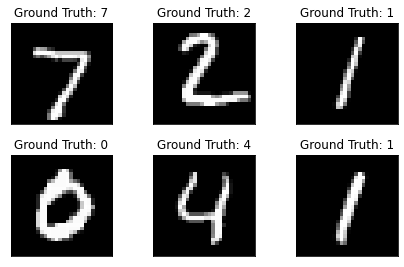

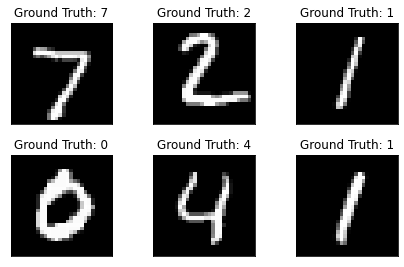

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

fig

In [5]:
def correlaton(x,y):
  return torch.sum((x-torch.mean(x)) * (y-torch.mean(y))) / (torch.sqrt(torch.sum((x-torch.mean(x)) ** 2)) * torch.sqrt(torch.sum((y-torch.mean(y)) ** 2)))

In [6]:
class MAE(nn.Module):
    def __init__(self):
        super(MAE,self).__init__()
        self.view1_convolution_L1=nn.Conv2d(1,200,3)
        self.view2_convolution_L1=nn.Conv2d(1,200,3)
        self.view1_pooling_L=nn.MaxPool2d(2)
        self.view2_pooling_L=nn.MaxPool2d(2)
        self.view1_batch_norm_L1=nn.BatchNorm2d(200)
        self.view2_batch_norm_L1=nn.BatchNorm2d(200)
        self.view1_convolution_L2=nn.Conv2d(200,100,3)
        self.view2_convolution_L2=nn.Conv2d(200,100,3)
        self.view1_batch_norm_L2=nn.BatchNorm2d(100)
        self.view2_batch_norm_L2=nn.BatchNorm2d(100)
        self.view1_hidden_layer_1=nn.Linear(1000,640)
        self.view2_hidden_layer_1=nn.Linear(1000,640)
        self.view1_hidden_layer_2=nn.Linear(640,320)
        self.view2_hidden_layer_2=nn.Linear(640,320)
        self.joint_common_rep=nn.Linear(320,100)
        self.view1_hidden_Layer_decoding=nn.Linear(100,294)
        self.view2_hidden_Layer_decoding=nn.Linear(100,294)
        self.view1_Upsampling=nn.Upsample(size=(26,12))
        self.view2_Upsampling=nn.Upsample(size=(26,12))
        self.view1_deconvolution=nn.ConvTranspose2d(3,1,3)
        self.view2_deconvolution=nn.ConvTranspose2d(3,1,3)


    def forward(self,inp_view1,inp_view2):
        view1={}
        view2={}
        view1["Layer"] = self.view1_convolution_L1(inp_view1)
        view2["Layer"] = self.view2_convolution_L1(inp_view2)
        view1["Layer"] = F.relu(view1["Layer"])
        view2["Layer"] = F.relu(view2["Layer"])
        view1["Layer"] = self.view1_pooling_L(view1["Layer"])
        view2["Layer"] = self.view2_pooling_L(view2["Layer"])
        view1["Layer"] = self.view1_batch_norm_L1(view1["Layer"])
        view2["Layer"] = self.view2_batch_norm_L1(view2["Layer"])
        view1["Layer"] = self.view1_convolution_L2(view1["Layer"])
        view2["Layer"] = self.view2_convolution_L2(view2["Layer"])
        view1["Layer"] = F.relu(view1["Layer"])
        view2["Layer"] = F.relu(view2["Layer"])
        view1["Layer"] = self.view1_pooling_L(view1["Layer"])
        view2["Layer"] = self.view2_pooling_L(view2["Layer"])
        view1["Layer"] = self.view1_batch_norm_L2(view1["Layer"])
        view2["Layer"] = self.view2_batch_norm_L2(view2["Layer"])
        view1["Layer"] = view1["Layer"].view(-1,1000)
        view2["Layer"] = view2["Layer"].view(-1,1000)
        view1["Hidden_Layer_1"] = self.view1_hidden_layer_1(view1["Layer"])
        view2["Hidden_Layer_1"] = self.view2_hidden_layer_1(view2["Layer"])
        view1["Hidden_Layer_1"] = F.relu(view1["Hidden_Layer_1"])
        view2["Hidden_Layer_1"] = F.relu(view2["Hidden_Layer_1"])
        view1["Hidden_Layer_2"] = self.view1_hidden_layer_2(view1["Hidden_Layer_1"])
        view2["Hidden_Layer_2"] = self.view2_hidden_layer_2(view2["Hidden_Layer_1"])
        view1["Hidden_Layer_2"] = F.relu(view1["Hidden_Layer_2"])
        view2["Hidden_Layer_2"] = F.relu(view2["Hidden_Layer_2"])
        joint_common_representation = view1["Hidden_Layer_2"] + view2["Hidden_Layer_2"]
        joint_common_representation = self.joint_common_rep(joint_common_representation)
        joint_common_representation = F.relu(joint_common_representation)
        view1["reconstructed"] = self.view1_hidden_Layer_decoding(joint_common_representation)
        view2["reconstructed"] = self.view2_hidden_Layer_decoding(joint_common_representation)
        view1["reconstructed"] = F.relu(view1["reconstructed"])
        view2["reconstructed"] = F.relu(view2["reconstructed"])
        view1["reconstructed"] = view1["reconstructed"].reshape(-1,3,14,7)
        view2["reconstructed"] = view2["reconstructed"].reshape(-1,3,14,7)
        view1["reconstructed"] = self.view1_Upsampling(view1["reconstructed"])
        view2["reconstructed"] = self.view2_Upsampling(view2["reconstructed"])
        view1["reconstructed"] = self.view1_deconvolution(view1["reconstructed"])
        view2["reconstructed"] = self.view2_deconvolution(view2["reconstructed"])
        return view1,view2,joint_common_representation

In [9]:
model = MAE()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [11]:
def fit(model,train_loader,num_epoch,optimizer):
    ep=[]
    losses=[]    
    for epoch in range(0,num_epoch):
        count=0
        print("epoch: ",epoch)
        epoch_loss=0.0
        for image_batch in train_loader:
            count+=1
            print(count,end=" ")
            self_reconstruction_loss={}
            cross_reconstruction_loss={}
            step_computation_loss={}
            view1_batch = image_batch[0][0:50,0:1,0:28,0:14]
            init_view1 = torch.zeros(view1_batch.shape)
            view2_batch = image_batch[0][0:50,0:1,0:28,14:28]
            init_view2 = torch.zeros(view2_batch.shape)
            view1_original,view2_original,joint_common_representation = model(view1_batch,view2_batch)
            self_reconstruction_loss["L1"]=F.mse_loss(view1_original["reconstructed"],view1_batch)
            self_reconstruction_loss["L1"]+=F.mse_loss(view2_original["reconstructed"],view2_batch)
            view1_left,view2_left,JCR_left = model(view1_batch,init_view2)
            view1_right,view2_right,JCR_right = model(init_view1,view2_batch)
            cross_reconstruction_loss["L2"]=F.mse_loss(view1_left["reconstructed"],view1_batch)
            cross_reconstruction_loss["L2"]+=F.mse_loss(view2_left["reconstructed"],view2_batch)
            cross_reconstruction_loss["L3"]=F.mse_loss(view1_right["reconstructed"],view1_batch)
            cross_reconstruction_loss["L3"]+=F.mse_loss(view2_right["reconstructed"],view2_batch)
            cross_reconstruction_loss["L5"]=F.mse_loss(view1_left["reconstructed"],view1_right["reconstructed"])
            cross_reconstruction_loss["L5"]+=F.mse_loss(view2_left["reconstructed"],view2_right["reconstructed"])
            step_computation_loss["L4"]=F.mse_loss(view1_original["Hidden_Layer_1"],view2_original["Hidden_Layer_1"])
            step_computation_loss["L4"]+=F.mse_loss(view1_original["Hidden_Layer_2"],view2_original["Hidden_Layer_2"])
            correlation_loss={}
            lambda_L6=-0.02
            lambda1_L7=-0.003
            lambda2_L7=-0.05
            correlation_loss["L6"]=lambda_L6*correlaton(JCR_left,JCR_right)
            correlation_loss["L7"]=lambda1_L7*correlaton(view1_original["Hidden_Layer_1"],view2_original["Hidden_Layer_1"]) 
            correlation_loss["L7"]+=lambda2_L7*correlaton(view1_original["Hidden_Layer_2"],view2_original["Hidden_Layer_2"]) 
            batch_loss=self_reconstruction_loss["L1"]+cross_reconstruction_loss["L2"]+cross_reconstruction_loss["L3"]+step_computation_loss["L4"]+cross_reconstruction_loss["L5"]+correlation_loss["L6"]+correlation_loss["L7"]
            epoch_loss+=batch_loss.item()
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
        losses.append(epoch_loss)
        ep.append(epoch)
    return losses,model,ep
        

In [12]:
loss,model2,ep=fit(model2,train_loader,5,optimizer)

epoch:  0
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 27

In [13]:
torch.save(model2.state_dict(), "model_2.pth")
# model2 = MAE()
# model2.load_state_dict(torch.load("model_1.pth"))

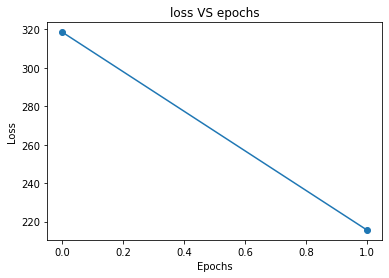

In [ ]:
plt.scatter(ep, loss)
plt.plot(ep, loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('loss VS epochs')
plt.show()

In [14]:
batch = next(iter(test_loader))
images = batch[0]
view1 = images[0:50,0:1,0:28,0:14]
init_view1 = torch.zeros(view1.shape)
view2 = images[0:50,0:1,0:28,14:28]
init_view2 = torch.zeros(view2.shape)
view1_original,view2_original,joint_common_representation = model2(view1,view2)
view1_left,view2_left,JCR_left = model2(view1,init_view2)
view1_right,view2_right,JCR_right = model2(init_view1,view2)

In [15]:
def plot_result(view1,view2,view2_original,view1_original,id):
    fig, axs = plt.subplots(2, 2,figsize=(70,70))
    axs[0, 0].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axs[0, 0].imshow(view1[id].detach().reshape(28,14))
    axs[0, 1].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axs[0, 1].imshow(view2_original["reconstructed"][id].detach().reshape(28,14))
    axs[1, 0].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axs[1, 0].imshow(view1_original["reconstructed"][id].detach().reshape(28,14))
    axs[1, 1].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    axs[1, 1].imshow(view2[id].detach().reshape(28,14))
    plt.subplots_adjust(left=0.65,bottom=0.1,right=0.7,top=0.2,wspace=0.1,hspace=0.1)
    plt.show()




Result 10


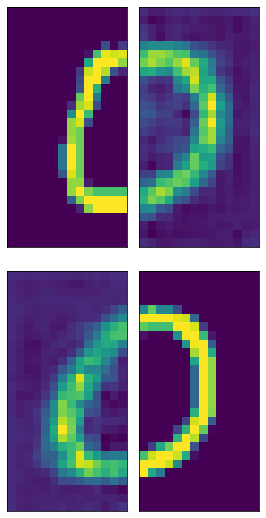




Result 11


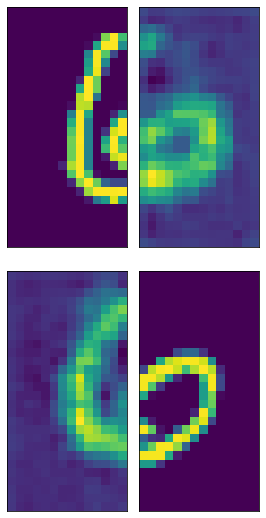




Result 12


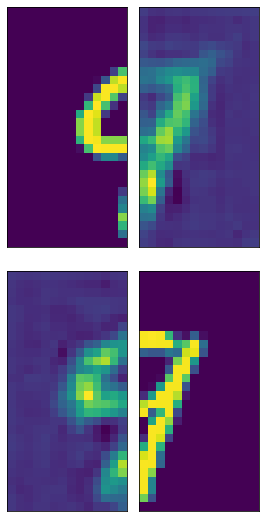




Result 13


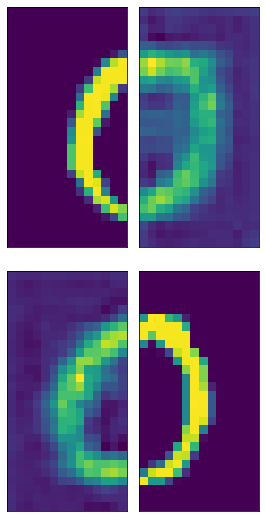




Result 14


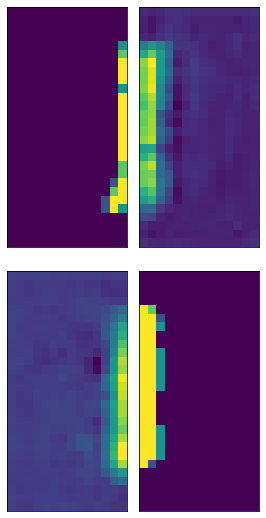




Result 15


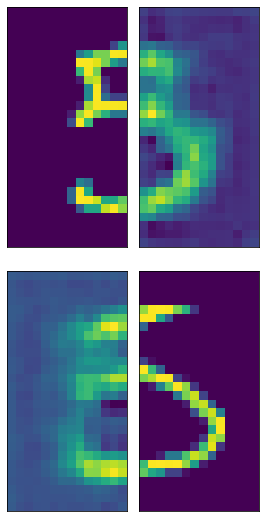




Result 16


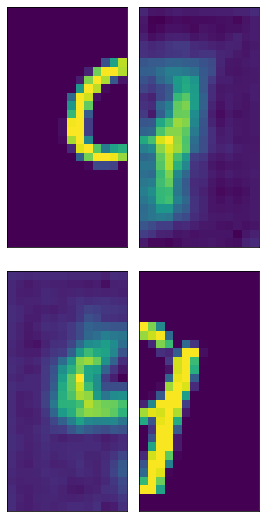




Result 17


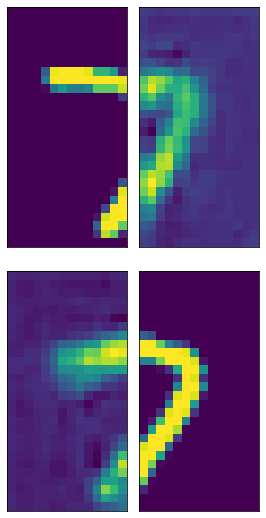




Result 18


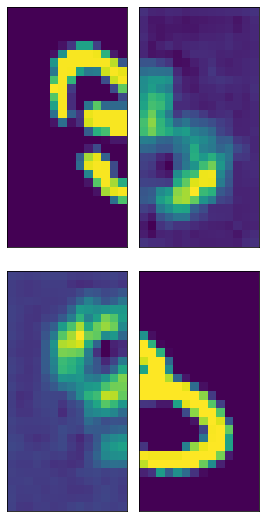




Result 19


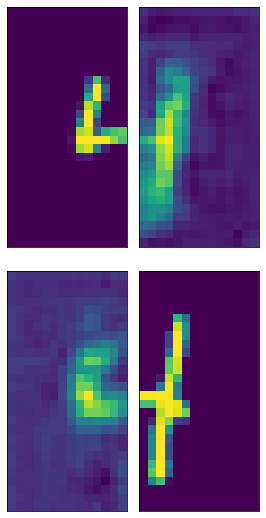




Result 20


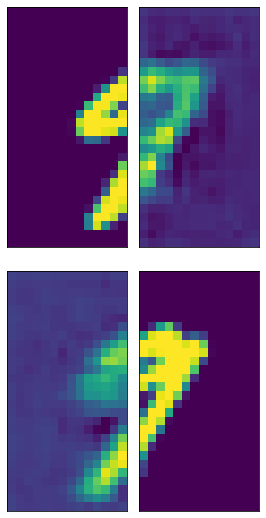




Result 21


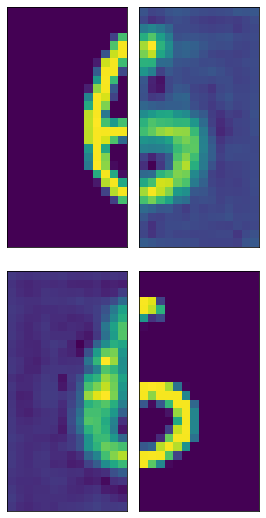




Result 22


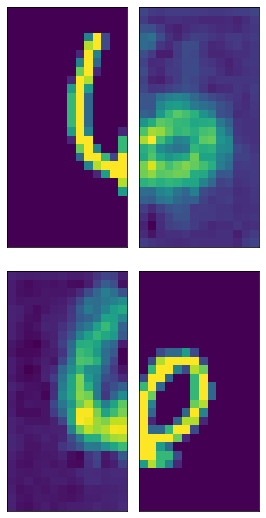




Result 23


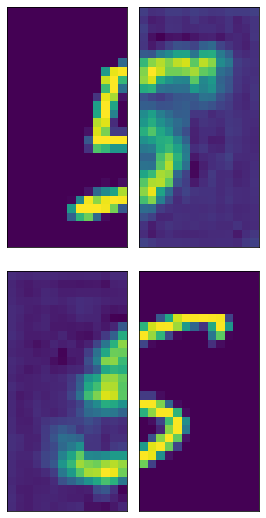




Result 24


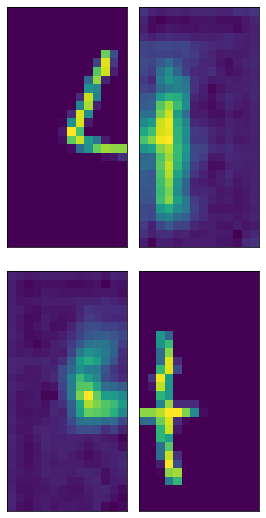




Result 25


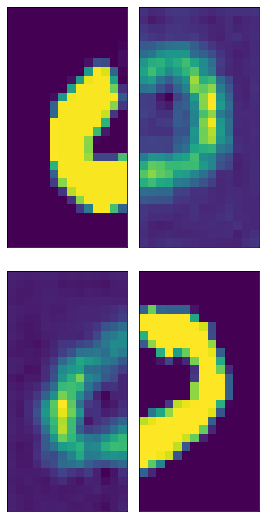




Result 26


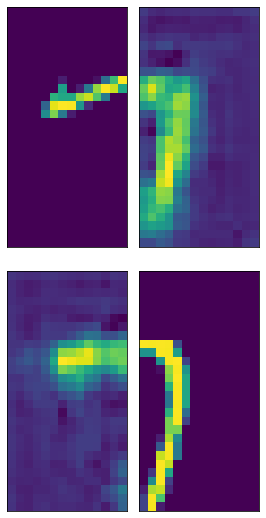




Result 27


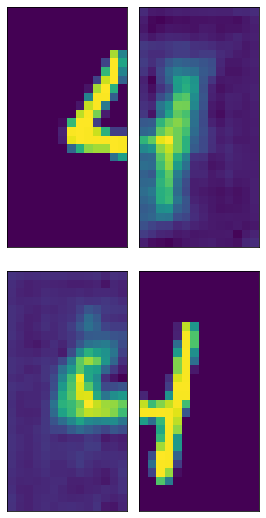




Result 28


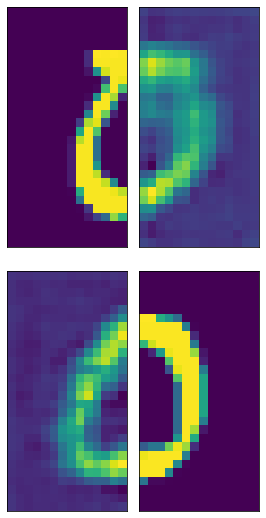




Result 29


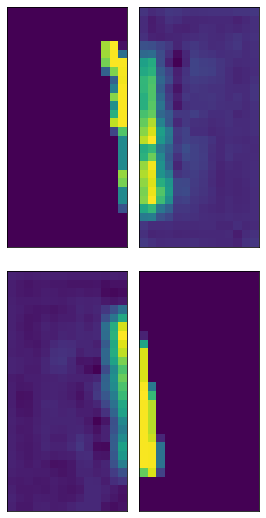

In [17]:
for id in range(10,30):
  print("\n"*2)
  print("Result",id)
  plot_result(view1,view2,view2_original,view1_original,id)